
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [23]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
#styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
#HTML(styles)
import warnings
warnings.filterwarnings('ignore')

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

In [3]:
# My includes
k_blue ='#19647E'

# Some code to build a status bar
from IPython.display import clear_output

def updateStatusBar(progress):
    bar_length = 40
    progress = float(progress)
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(bar_length * progress)

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [4]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [5]:
# Normalize Data
X_train_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)

display(X_train_n.head(5))

X_test_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,0.621681,0.321146,...,0.477952,0.622254,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,0.674740,0.341671,...,0.435211,0.519185,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,0.289416,0.329466,...,0.410134,0.253019,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,0.395238,0.394697,...,0.474741,0.450396,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,0.505418,0.301920,...,0.263812,0.532818,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [6]:
# Unregularized Logistic Regression - All Predictors
lr = LogisticRegression(C=100000, solver='liblinear')
lr.fit(sm.add_constant(X_train_n), y_train)

y_hat_train = lr.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using all predictors from model')
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))
print('Coefficients:', lr.coef_[0])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Using all predictors from model
Training Accuracy: 100.0%
Test Accuracy: 76.16%
Coefficients: [-0.00894277  0.6290044   0.16160074 ... -0.15769538  0.37397142
  0.32678875]


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [7]:
# Run logistic regression using LASSO-like regularization and Cross-Validation
Cs = 10.0**np.arange(-5,5)
lrcv = LogisticRegressionCV(Cs = Cs, cv=5, solver='liblinear', penalty='l1')
lrcv.fit(sm.add_constant(X_train_n), y_train)

y_hat_train = lrcv.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lrcv.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using penalty \'l1\' on logistic regression. {0} coefficients remaining of {1}'.format(
    np.count_nonzero(lrcv.coef_[0]),len(lrcv.coef_[0])))
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Using penalty 'l1' on logistic regression. 169 coefficients remaining of 7130
Training Accuracy: 95.34%
Test Accuracy: 78.81%


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [8]:
ks = [1,2,3,4,5,7,9,10,15,25]
cvs = np.zeros(len(ks))

for k in ks:
    i = ks.index(k)
    updateStatusBar(float(i)/len(ks))  # Update timer
    knn = KNeighborsClassifier(k)
    knn.fit(sm.add_constant(X_train_n), y_train)
    cvs[i] = np.mean(cross_val_score(knn, X_train_n, y_train, cv=5))
updateStatusBar(1)
display(cvs)

Progress: [########################################] 100.0%


array([0.8153344 , 0.80194458, 0.86531009, 0.83539135, 0.85690673,
       0.87517189, 0.87178276, 0.84861449, 0.83186332, 0.74546844])

In [9]:
# Choose k
k = ks[np.argmax(cvs)]
print('The ideal value for K is:', k)

knn = KNeighborsClassifier(k)
knn.fit(sm.add_constant(X_train_n), y_train)
y_hat_train_knn = knn.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train_knn)
y_hat_test_knn = knn.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test_knn)

print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))

The ideal value for K is: 7


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Training Accuracy: 90.18%
Test Accuracy: 86.09%


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [10]:
import sklearn.metrics as met
cols = df.columns#[1:]
#print(df[cols].shape)
#print(X_train_n.shape)
#print(dir(lr))


lr_yhat = lr.predict_proba(sm.add_constant(X_test_n))[:,1]
lrcv_yhat = lrcv.predict_proba(sm.add_constant(X_test_n))[:,1]
knn_yhat = knn.predict_proba(sm.add_constant(X_test_n))[:,1]


print('The confusion matrix for an unregularized multiple logistic regresion model is: \n',met.confusion_matrix(y_test, lr_yhat>0.5))
print('The confusion matrix for a regularized multiple logistic regresion model is: \n',met.confusion_matrix(y_test, lrcv_yhat>0.5))
print('The confusion matrix for a KNN model where K={} is: \n'.format(k), met.confusion_matrix(y_test, knn_yhat>0.5))


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The confusion matrix for an unregularized multiple logistic regresion model is: 
 [[65 12]
 [24 50]]
The confusion matrix for a regularized multiple logistic regresion model is: 
 [[67 10]
 [22 52]]
The confusion matrix for a KNN model where K=7 is: 
 [[67 10]
 [11 63]]


The false positives rates are 24%, 19%, and 19% (12/50, 10/53, and 10/53) and false negative rates are 37%, 31%, and 31% (24/65, 21/67, and 21/67) for unregularized multiple logistic regression, regularized multiple logistic regression, and KNN where K = 25 respectively.  The unregularized data seems to have a greater error rate, and the regularized data has the exact same results as the KNN regression.

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [11]:
# Create/fit the 'full'  PCA transformation
pca = PCA().fit(X_train_n)

# Apply the PCA transformation to the full predictor set
X_train_pca = pca.transform(X_train_n)
X_test_pca = pca.transform(X_test_n)

# Convert to a dataframe
X_train_pca = pd.DataFrame(X_train_pca).set_index(X_train_n.index)
X_test_pca = pd.DataFrame(X_test_pca).set_index(X_test_n.index)

print(X_train_n.shape)
print(X_train_pca.shape)
print(X_test_pca.shape)

(601, 7129)
(601, 601)
(151, 601)


The limiting factor on the maximum number of PCA components is the number of samples (n) in the dataset.

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

<Figure size 432x288 with 0 Axes>

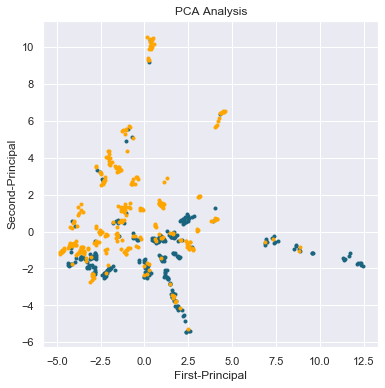

In [12]:
# Plot two best PCA vectors
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

axes.scatter(X_train_pca.iloc[:,0][y_train == 1],X_train_pca.iloc[:,1][y_train == 1], 
                color=k_blue, marker='.', label='cancer type: AMLt');
axes.scatter(X_train_pca.iloc[:,0][y_train == 0],X_train_pca.iloc[:,1][y_train == 0],
                color='orange', marker='.', label='cancer type: ALLt');
axes.set_title('PCA Analysis');
axes.set_xlabel('First-Principal');
axes.set_ylabel('Second-Principal');

It gives a snapshot of the highest-variance components of the underlying data, which are orthoginal to one-another. By looking at a plot of the top-two components, we can estimate how seperable the classifiers are between these top two bases. Essentially, it reduces the dimensionality of our original data-set down to the two bases that capture the most information.

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

<Figure size 432x288 with 0 Axes>

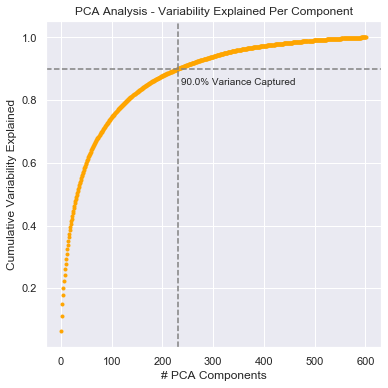

Variance captured in top two Principal Components: 0.064 + 0.049 = 11.3%
Principal Components required for 90.0% variance captured: 231


In [13]:
# Plot variability of PCA components
var_explained = pca.explained_variance_ratio_
var_cumulative = np.cumsum(var_explained)

target_var_capture = 0.9
var_capture = 1 + np.min(np.where(var_cumulative > target_var_capture))

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

axes.scatter(1 + np.arange(0,len(var_explained)), var_cumulative, color='orange', marker='.');
axes.set_title('PCA Analysis - Variability Explained Per Component');
axes.set_xlabel('# PCA Components');
axes.set_ylabel('Cumulative Variability Explained');
axes.axvline(x = var_capture, ls='--', color='grey')
axes.axhline(y = target_var_capture, ls='--', color='grey')
axes.text(var_capture + 5, target_var_capture - 0.05, '{:.3}% Variance Captured'.format(100*target_var_capture))
plt.show();

print('Variance captured in top two Principal Components: {:.2} + {:.2} = {:.3}%'.format(
    pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1], 100*var_cumulative[1]))
print('Principal Components required for {:.3}% variance captured: {}'.format(
    100*target_var_capture, var_capture))

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

<Figure size 432x288 with 0 Axes>

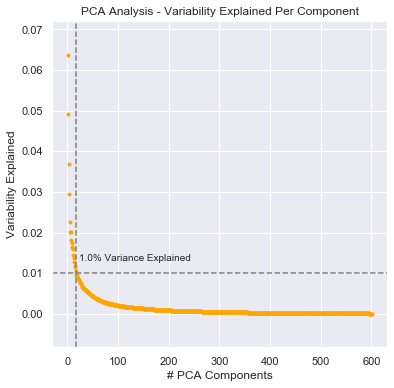

Threshold at less than 1.0% variance captured: 18 components


In [14]:
# Plot variability of PCA components
var_explained = pca.explained_variance_ratio_
var_cumulative = np.cumsum(var_explained)

target_i_var_capture = 0.01
var_i_capture = 1 + np.min(np.where(var_explained < target_i_var_capture))

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

axes.scatter(1 + np.arange(0,len(var_explained)), var_explained, color='orange', marker='.');
axes.set_title('PCA Analysis - Variability Explained Per Component');
axes.set_xlabel('# PCA Components');
axes.set_ylabel('Variability Explained');
axes.axvline(x = var_i_capture, ls='--', color='grey')
axes.axhline(y = target_i_var_capture, ls='--', color='grey')
axes.text(var_i_capture + 5, target_i_var_capture + 0.003, '{:.3}% Variance Explained'.format(100*target_i_var_capture))
plt.show();

print('Threshold at less than {:.3}% variance captured: {} components'.format(
    100*target_i_var_capture, var_i_capture))

We chose to ommit any Principal Component that individually explained less than 1% of the variance. By fixing the variance at a set threshold, rather than looking at the cummulative variance, we hope to focus purely on the bases that have the most predictive power.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [20]:
# Unregularized Logistic Regression - All Predictors
pcas = [2, var_i_capture, var_capture]
for p in pcas:
    lr = LogisticRegression(C=100000, solver='liblinear')
    lr.fit(sm.add_constant(X_train_pca.iloc[:,0:(p)]), y_train)

    y_hat_train = lr.predict(sm.add_constant(X_train_pca.iloc[:,0:(p)]))
    train_accuracy = accuracy_score(y_train.values, y_hat_train)
    y_hat_test = lr.predict(sm.add_constant(X_test_pca.iloc[:,0:(p)]))
    test_accuracy = accuracy_score(y_test.values, y_hat_test)

    print('Using top {} components from PCA'.format(p))
    print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
    print('Test Accuracy: {:.4}%\n'.format(test_accuracy*100))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

Using top 2 components from PCA
Training Accuracy: 75.71%
Test Accuracy: 80.13%

Using top 18 components from PCA
Training Accuracy: 88.35%
Test Accuracy: 82.78%

Using top 231 components from PCA
Training Accuracy: 100.0%
Test Accuracy: 69.54%



C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The lowest 2 components don't capture enough of the variance in the data to provide a strong score. However, it may be acceptable given how simple the model is, using only two coefficients. On the other end, the 90% variance model appears to be overfit, as the training set shows 100% accuracy, but the test accuracy is significantly lower. The best result seems to be the value we chose above, which excludes any components below 1%.

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [31]:
test_pcas = [2, 15, var_i_capture, 25, 35, 50, 
             60, 75, 100, 150, 200, 300, 400, var_capture]
max_test_accuracy = 0
max_train_accuracy = 0
max_pca = 0

for p in test_pcas:
# lr = LogisticRegression(Cs=100000, cv=5, solver='lbfgs', max_iter = 10000)
# 1 - np.mean(cross_val_score(lr, X_train, y_train, cv=5))
    i = test_pcas.index(p)
    updateStatusBar(float(i)/len(test_pcas))  # Update timer
    
    lr = LogisticRegressionCV(cv=5, solver='lbfgs', max_iter = 10000)
    lr.fit(sm.add_constant(X_train_pca.iloc[:,0:(p)]), y_train)

    y_hat_train = lr.predict(sm.add_constant(X_train_pca.iloc[:,0:(p)]))
    train_accuracy = accuracy_score(y_train.values, y_hat_train)
    y_hat_test = lr.predict(sm.add_constant(X_test_pca.iloc[:,0:(p)]))
    test_accuracy = accuracy_score(y_test.values, y_hat_test)
    
    if (test_accuracy > max_test_accuracy):
        max_test_accuracy = test_accuracy
        max_train_accuracy = train_accuracy
        max_pca = p
updateStatusBar(1)  # Update timer

print('Using top {} components from PCA using CV'.format(max_pca))
print('Training Accuracy: {:.4}%'.format(max_train_accuracy*100))
print('Test Accuracy: {:.4}%\n'.format(max_test_accuracy*100))

Progress: [########################################] 100.0%
Using top 60 components from PCA using CV
Training Accuracy: 90.18%
Test Accuracy: 86.75%



In [60]:
# Redo LR at maximum PCA
lr = LogisticRegressionCV(cv=5, solver='lbfgs', max_iter = 10000)
lr.fit(sm.add_constant(X_train_pca.iloc[:,0:(max_pca)]), y_train)

y_hat_train = lr.predict(sm.add_constant(X_train_pca.iloc[:,0:(max_pca)]))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr.predict(sm.add_constant(X_test_pca.iloc[:,0:(max_pca)]))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

# Transform to beta
betas = (lr.coef_*np.transpose(pca.components_[0:max_pca+1,:])).sum(axis=1)
gene_index = np.where(X_train.columns.values == 'M31523_at')
print('The beta coefficient for M31523_at is {:.5}'.format(
    betas[gene_index][0]))
print('The max beta coefficient is {:.5}'.format(np.max(np.abs(betas))))
print('The sum of PCA component for M31523_at is {:.5}'.format(
    np.sum(pca.components_[0:max_pca+1,gene_index])))
print('The max sum of PCA components is {:.5}'.format(
    np.max(np.sum(pca.components_[0:max_pca+1,:], axis=0))))

The beta coefficient for M31523_at is 0.006951
The max beta coefficient is 0.032857
The sum of PCA component for M31523_at is 0.019215
The max sum of PCA components is 0.32931


The Principal Component Analysis is not giving much weight to the M31523_at gene. The beta coefficient is only 0.007, and the weighting of the component in the PCA analysis is 0.02. Compared to the weighting of some of the other predictors, M31523_at does not have much on an effect.

One of the downsides of PCA is that it does not increase the explainability of the model. This is a case where we have a single predictor with high predictive power that is being ommitted in favor of a number of other predictors that collectively have higher predictive power.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [19]:
# your code here
X_train_pca.iloc[:,0]

486    -0.643819
604    -1.966286
341    -2.267028
117     1.154839
516     0.151636
462     1.600488
287    -0.298117
331    -1.042056
545    -1.032586
700     3.135099
629     0.120547
275     1.035767
567     0.976627
278    -2.746424
603    -3.008673
252    -0.715463
742    -2.779969
197    -1.175810
78      8.502332
361     2.751857
632    -0.341990
649    -3.182447
547    -2.019798
707     0.904761
664     1.192895
746    -1.945825
612     1.900388
223     2.348940
464     1.731050
416    -1.492251
         ...    
618    -3.248162
190    -2.972355
560    -1.528201
380    -1.081547
711    -2.041671
145     3.113019
437     1.749738
461     0.623669
292    -0.708587
282     0.196282
150    -2.403600
422    -4.110096
609    -2.303228
127    -3.024727
673     3.037316
263    -3.921665
230     1.104517
298    12.183180
239    -4.023895
602    -4.099651
652    -2.234342
285     0.369178
211    -2.295540
597     2.535291
38      0.983369
171    -2.823378
39     -0.169707
216    -0.5529

*your answer here*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [0]:
compas_df = pd.read_csv('data/compas.csv')

# your code here



**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [0]:
# your code here


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [0]:
# your code here


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [0]:
# your code here


**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*


---